### 5.3 Categorical variables

A common question for statistical methods is to what extent an outcome changes as a result of presence or absence of a category. A category here means discrete and unordered.

* Sex: male, female
* Developmental status: infant, juvenile, adult
* Geographic region: Africa, Europe, Melanesia


Some of them are **apes**, while others are **New World monkeys**.

In [2]:
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm

from scipy import stats
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Binary categories

In [3]:
df_howell = pd.read_csv("Howell1.csv", delimiter=";")
df_howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
df_howell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


- The male variable is our new predictor, an example of a **indicator variable**. Indicator variables—sometimes also called “dummy” variables—are devices for encoding unordered categories into quantitative models
- So it takes the value 1 whenever the person is male, but it takes the value 0 when the person belongs to any other category.

In [5]:
sex = df_howell["male"].values

### Simulate the priors

* The parameter βm influences prediction only for those cases where m = 1. When m = 0, it has no effect on prediction
* Using this approach means that βm represents the expected difference between males and females in height.

In [6]:
# Generate random samples for mu_female and mu_male
mu_female = np.random.normal(178, 20, 10000)
mu_male = np.random.normal(178, 20, 10000) + np.random.normal(0, 10, 10000)

# Create a DataFrame
data = pd.DataFrame({'mu_female': mu_female, 'mu_male': mu_male})

# Summary statistics (similar to precis in R)
summary = data.describe(percentiles=[0.025, 0.5, 0.975])
summary

,mu_female,mu_male
count,10000.000000,10000.000000
mean,178.256608,178.117779
std,20.127976,22.303922
min,109.522548,102.516702
2.5%,138.714325,134.233494
50%,178.365633,178.086921
97.5%,217.676009,222.261503
max,251.105749,259.596960


The prior for males is wider, because it uses both parameters. While in a regression this simple, these priors will wash out very quickly, in general we should be careful.

### Model with Index Variable for sex

In [7]:
# Assuming 'd' is a pandas DataFrame
# Add a new column 'sex' based on the 'male' column
df_howell["sex"] = np.where(df_howell["male"] == 1, 2, 1)

# Check the structure of the new 'sex' column
print(df_howell["sex"].dtype)  # Display the data type of the column
df_howell["sex"].head()  # Show the first few values of the column


int32


0    2
1    1
2    1
3    2
4    1
Name: sex, dtype: int32

Now “1” means female and “2” means male.

In [8]:
# Assuming 'd' is a pandas DataFrame with 'height' and 'sex'
# Normalize 'sex' to start from 0 for PyMC indexing
df_howell["sex"] = df_howell["sex"] - 1  # Convert to 0 and 1 for PyMC indexing

with pm.Model() as model_m5_8:
    # Priors
    a = pm.Normal("a", mu=178, sigma=20, shape=2)  # Group-specific intercepts for sex
    sigma = pm.Uniform("sigma", lower=0, upper=50)  # Prior for standard deviation
    
    # Likelihood
    mu = a[df_howell["sex"]]  # Use 'sex' to index the group-specific intercepts
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df_howell["height"])
    
    # Inference
    trace_m5_8 = pm.sample(1000, return_inferencedata=True)

# Summary of the model
summary = az.summary(trace_m5_8, var_names=["a", "sigma"], round_to=2)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


C:\git\sagemaker_job_tracking\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 174 draw iterations (3_000 + 522 draws total) took 858 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],134.87,1.64,131.86,137.84,0.06,0.04,759.23,351.82,1.0
a[1],142.59,1.80,138.79,145.95,0.06,0.04,945.07,460.40,1.0
sigma,27.40,0.80,25.99,28.94,0.03,0.02,677.43,318.84,1.0


Interpreting these parameters is easy enough—they are the expected heights in each category.

In [30]:
# Extract posterior samples as a DataFrame
posterior = trace_m5_8.posterior.to_dataframe()

# Calculate the difference between a[1] (female) and a[2] (male)
diff_fm_summary = pd.DataFrame({
    "mean": [summary.loc["a[0]"]["mean"], summary.loc["a[1]"]["mean"],  summary.loc["a[0]"]["mean"] - summary.loc["a[1]"]["mean"]],
    "sd": [summary.loc["a[0]"]["sd"], summary.loc["a[1]"]["sd"],  summary.loc["a[0]"]["sd"] - summary.loc["a[1]"]["sd"]],
}, index=["a[0]", "a[1]", "diff_fm"])

# Summarize the posterior distribution
diff_fm_summary.head()

,mean,sd
a[0],134.87,1.64
a[1],142.59,1.80
diff_fm,-7.72,-0.16


difference between a female and male in the sample. This kind of calculation is called a **contrast**

### Many Categories

- Binary categories are easy
- But when there are more than two categories, the indicator variable approach explodes.
- You’ll need a new indicator variable for each new category

In [31]:
df_milk = pd.read_csv("milk.csv")

# Display the structure of the dataset
print(df_milk.info())

# Optionally display a preview of the dataset
df_milk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      29 non-null     int64  
 1   clade           29 non-null     object 
 2   species         29 non-null     object 
 3   kcal.per.g      29 non-null     float64
 4   perc.fat        29 non-null     float64
 5   perc.protein    29 non-null     float64
 6   perc.lactose    29 non-null     float64
 7   mass            29 non-null     float64
 8   neocortex.perc  17 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.2+ KB
None


,Unnamed: 0,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,1,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,2,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,3,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,4,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,5,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [32]:
df_milk["clade"].unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

### Convert the clade category to an int value

In [36]:
# Ensure 'clade' is treated as a categorical variable
df_milk["clade"] = df_milk["clade"].astype("category")

# Convert 'clade' to integer IDs
df_milk["clade_id"] = df_milk["clade"].cat.codes + 1  # Adding 1 to match R's 1-based indexing

df_milk.head()

,Unnamed: 0,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id
0,1,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,4
1,2,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,4
2,3,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,4
3,4,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,4
4,5,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,4


In [40]:
# Assuming 'd' is a pandas DataFrame and 'clade' is already categorical
# Standardize the 'kcal.per.g' column
df_milk["K"] = (df_milk["kcal.per.g"] - df_milk["kcal.per.g"].mean()) / df_milk["kcal.per.g"].std()

# Ensure 'clade' is categorical and create clade_id
df_milk["clade"] = df_milk["clade"].astype("category")
df_milk["clade_id"] = df_milk["clade"].cat.codes  # 0-based indexing for PyMC

# Define the model
with pm.Model() as model_m5_9:
    # Priors
    a = pm.Normal("a", mu=0, sigma=0.5, shape=len(df_milk["clade"].cat.categories))  # Group-specific intercepts
    sigma = pm.Exponential("sigma", lam=1)  # Standard deviation

    # Likelihood
    mu = a[df_milk["clade_id"]]  # Index a by clade_id
    K_obs = pm.Normal("K", mu=mu, sigma=sigma, observed=df_milk["K"])

    # Sampling
    trace_m5_9 = pm.sample(1000, return_inferencedata=True)

# Generate summary
summary = az.summary(trace_m5_9, var_names=["a"], round_to=2)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


C:\git\sagemaker_job_tracking\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.46,0.23,-0.90,-0.04,0.0,0.0,4348.46,3034.07,1.0
a[1],0.35,0.23,-0.10,0.78,0.0,0.0,5016.64,3331.06,1.0
a[2],0.64,0.28,0.12,1.16,0.0,0.0,5165.80,3109.34,1.0
a[3],-0.54,0.29,-1.07,0.01,0.0,0.0,4576.45,3300.68,1.0


Remember, K is the standardized kilocalories. I widened the prior on α a little, to allow the different clades to disperse, if the data wants them to

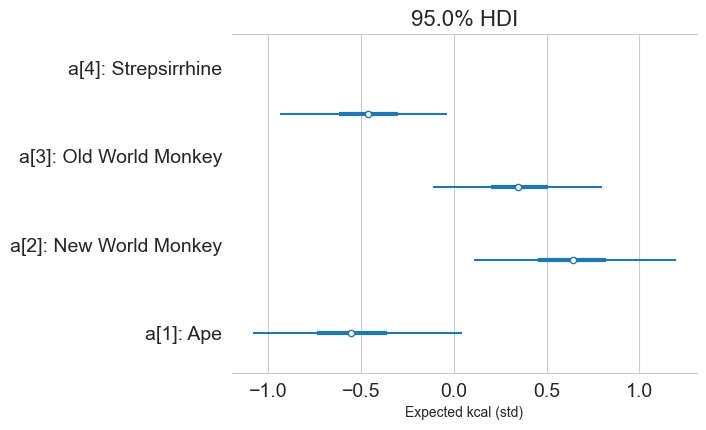

In [47]:
# Labels for the plot
labels = [f"a[{i + 1}]: {clade}" for i, clade in enumerate(df_milk["clade"].cat.categories)]

# Plot posterior summaries
az.plot_forest(
    trace_m5_9,
    var_names=["a"],
    combined=True,
    hdi_prob=0.95,
    kind="forestplot",
)

plt.xlabel("Expected kcal (std)")
plt.yticks(range(len(labels)), labels)
plt.show()

### Add another categorical variable

For example, let’s randomly assign these primates to some made
up categories: [1] Gryffindor, [2] Hufflepuff, [3] Ravenclaw, and [4] Slytherin

In [43]:
# Set seed for reproducibility
np.random.seed(63)

# Create the 'house' column
houses = np.tile(np.arange(1, 5), 8)  # Replicate 1:4 (4 groups) each 8 times
df_milk["house"] = np.random.choice(houses, size=len(df_milk), replace=False)

# Display the first few rows of the new column
print(df_milk[["house"]].head())


   house
0      1
1      3
2      2
3      2
4      3


In [45]:
# Ensure 'house' is also categorical and create house_id
df_milk["house"] = df_milk["house"].astype("category")
df_milk["house_id"] = df_milk["house"].cat.codes  # Convert to 0-based indexing

# Define the model
with pm.Model() as model_m5_10:
    # Priors for clade and house group effects
    a = pm.Normal("a", mu=0, sigma=0.5, shape=len(df_milk["clade"].cat.categories))  # Group-level intercept for clade
    h = pm.Normal("h", mu=0, sigma=0.5, shape=len(df_milk["house"].cat.categories))  # Group-level intercept for house

    # Prior for sigma
    sigma = pm.Exponential("sigma", lam=1)  # Prior for standard deviation

    # Expected value of K
    mu = a[df_milk["clade_id"]] + h[df_milk["house_id"]]  # Combine clade and house effects

    # Likelihood
    K_obs = pm.Normal("K", mu=mu, sigma=sigma, observed=df_milk["K"])

    # Sampling
    trace_m5_10 = pm.sample(1000, return_inferencedata=True)

# Summarize the model
summary = az.summary(trace_m5_10, var_names=["a", "h", "sigma"], round_to=2)
summary


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, h, sigma]


C:\git\sagemaker_job_tracking\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.61,0.28,-1.10,-0.05,0.01,0.0,2977.66,3332.03,1.0
a[1],0.34,0.27,-0.13,0.86,0.01,0.0,2744.86,2810.63,1.0
a[2],0.79,0.31,0.21,1.36,0.01,0.0,2992.11,2893.69,1.0
a[3],-0.55,0.30,-1.10,0.07,0.00,0.0,3989.98,3062.22,1.0
h[0],-0.52,0.28,-1.01,0.06,0.01,0.0,3084.37,3072.59,1.0
h[1],-0.07,0.27,-0.58,0.43,0.00,0.0,3410.24,3200.41,1.0
h[2],0.15,0.28,-0.40,0.64,0.01,0.0,3007.23,3107.12,1.0
h[3],0.41,0.29,-0.14,0.92,0.01,0.0,3016.81,3017.67,1.0
sigma,0.69,0.11,0.49,0.91,0.00,0.0,3228.77,2950.77,1.0


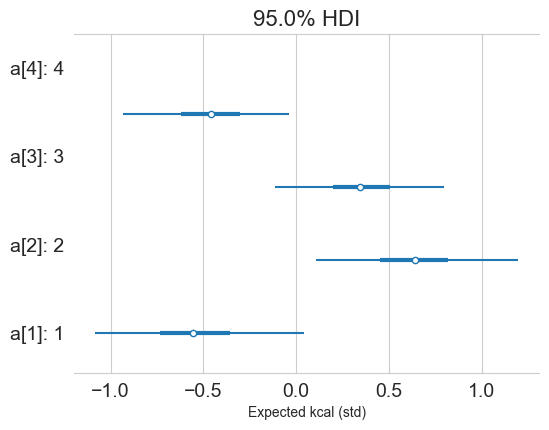

In [46]:
# Labels for the plot
labels = [f"a[{i + 1}]: {house}" for i, house in enumerate(df_milk["house"].cat.categories)]

# Plot posterior summaries
az.plot_forest(
    trace_m5_9,
    var_names=["a"],
    combined=True,
    hdi_prob=0.95,
    kind="forestplot",
)

plt.xlabel("Expected kcal (std)")
plt.yticks(range(len(labels)), labels)
plt.show()